Plot time series of temperature, mass loss, and sea level rise for a single ensemble member

SSP: 245
ESM: EC-Earth 3
ISM: CISM_NCA

Plot iterations, highlighting first and last

Plot T, ML, SLR for each basin and Antarctic-wide (6x3 plots)

In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
ds = xr.open_dataset('../data/dummy.nc')
ds = ds.sel(ism='CISM_NCA',esm='EC-Earth3',ssp='245')
ds = ds.isel(exp=slice(0,5))
ds

<xarray.Dataset>
Dimensions:  (time: 150, basin: 5, rftime: 150, exp: 5)
Coordinates:
  * time     (time) int64 1950 1951 1952 1953 1954 ... 2095 2096 2097 2098 2099
    esm      <U9 'EC-Earth3'
    ssp      <U3 '245'
  * basin    (basin) object 'EAIS' 'ROSS' 'AMUN' 'WEDD' 'PENS'
  * rftime   (rftime) int64 0 1 2 3 4 5 6 7 ... 142 143 144 145 146 147 148 149
  * exp      (exp) object 'EAIS' 'ROSS' 'AMUN' 'WEDD' 'PENS'
    ism      <U8 'CISM_NCA'
Data variables:
    temp     (time, basin) float64 ...
    orf      (rftime, exp, basin) float64 ...
    irf      (rftime, basin) float64 ...
    srf      (rftime, basin) float64 ...

In [3]:
def oce2ice(TMP,IRF,bm=8):
    #Input:
    #TMP: 5 temperature time series
    #IRF: Ice response function
    #bm: basal melt sensitivity [m/yr /degC]
    #Output:
    #IML: Ice mass loss for 5 regions [Gt/yr]
    assert TMP.shape == IRF.shape
    IML = 0.*TMP
    for t,tt in enumerate(IRF.rftime):
        if t==0: continue
        for b,bas in enumerate(IRF.basin):
            dFdt = TMP[1:t,b]-TMP[:t-1,b]
            CRF = IRF[1:t,b].values
            IML[t,b] = bm*np.sum(CRF*dFdt)
            #print(t,b,T[1:t,b].values,T[:t-1,b].values,dFdt)
            #print(t,b,dFdt,CRF,out[t,b].values)
    return IML

In [4]:
def oce2slr(TMP,SRF,bm=8):
    #Input:
    #TMP: 5 temperature time series
    #SRF: Sealevel response function
    #bm: basal melt sensitivity [m/yr /degC]
    #Output:
    #SLR: Cumulative sea level rise for 5 regions [m]
    assert TMP.shape == SRF.shape
    SLR = 0.*TMP
    for t,tt in enumerate(SRF.rftime):
        if t==0: continue
        for b,bas in enumerate(SRF.basin):
            dFdt = TMP[1:t,b]-TMP[:t-1,b]
            CRF = SRF[1:t,b].values
            SLR[t,b] = bm*np.sum(CRF*dFdt)
            #print(t,b,T[1:t,b].values,T[:t-1,b].values,dFdt)
            #print(t,b,dFdt,CRF,out[t,b].values)
    return np.cumsum(SLR,axis=0)

In [5]:
def ice2oce(IML,ORF):
    #Input:
    #IML: 5 ice mass loss time series
    #ORF: Ocean response function
    #Output:
    #TMP: Temperature anomaly for 5 regions [degC]
    assert IML.shape == ORF.shape[:2]
    assert ORF.shape[1] == ORF.shape[2]
    TMP = 0.*IML
    for t,tt in enumerate(ORF.rftime):
        if t==0: continue
        for e,ex in enumerate(ORF.exp):
            dFdt = IML[1:t,e]-IML[:t-1,e]
            for b,bas in enumerate(ORF.basin):
                CRF = ORF[1:t,e,b].values
                TMP[t,b] += np.sum(CRF*dFdt)
    return TMP

In [7]:
def iterate(tmp,orf,irf,srf,niter=10):
    TMP = np.zeros((niter,len(ds.time),len(ds.basin)))
    IML = np.zeros((niter,len(ds.time),len(ds.basin)))
    SLR = np.zeros((niter,len(ds.time),len(ds.basin)))
    TMP[0,:,:] = tmp.values
    IML[0,:,:] = oce2ice(TMP[0,:,:],irf)
    SLR[0,:,:] = oce2slr(TMP[0,:,:],srf)
    for n in range(1,niter):
        TMP[n,:,:] = tmp.values + ice2oce(IML[n-1,:,:],orf)
        IML[n,:,:] = oce2ice(TMP[n,:,:],irf)
        SLR[n,:,:] = oce2slr(TMP[n,:,:],srf)
    return TMP,IML,SLR

In [11]:
TMP,IML,SLR = iterate(ds.temp,ds.orf,ds.irf,ds.srf)

In [12]:
mpl.rcParams['lines.linewidth'] = 2.
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.titlesize'] = 9
mpl.rcParams['axes.labelsize'] = 9
mpl.rcParams['legend.fontsize'] = 9
mpl.rcParams['figure.subplot.wspace'] = .1
mpl.rcParams['figure.subplot.left'] = .1
mpl.rcParams['figure.subplot.right'] = .99
mpl.rcParams['figure.figsize'] = (7,5)
bcol = ['tab:blue','tab:orange','tab:red','tab:purple','tab:green']

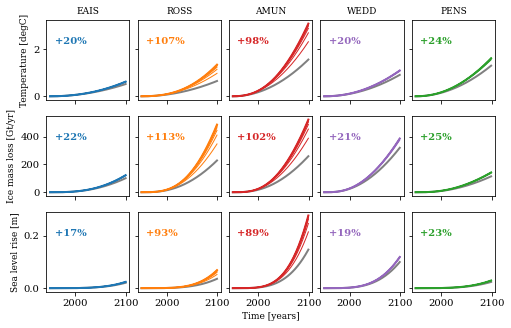

In [13]:
fig,ax = plt.subplots(3,5,sharex=True,sharey='row')

niter = TMP.shape[0]
lws = np.ones(niter)
lws[0] = 2
lws[-1] = 2

for b,bas in enumerate(ds.basin.values):
    for v,var in enumerate([TMP,IML,SLR]):
        dax = ax[v,b]
        dax.plot(ds.time,var[0,:,b],c='.5',lw=lws[0])
        for n in range(1,niter):
            dax.plot(ds.time,var[n,:,b],c=bcol[b],lw=lws[n])
        dax.text(.1,.7,f"{100*(var[-1,-1,b]-var[0,-1,b])/var[0,-1,b]:+.0f}%",transform=dax.transAxes,weight='bold',c=bcol[b])
    
    ax[0,b].set_title(bas)
ax[-1,2].set_xlabel('Time [years]')
ax[0,0].set_ylabel('Temperature [degC]')
ax[1,0].set_ylabel('Ice mass loss [Gt/yr]')
ax[2,0].set_ylabel('Sea level rise [m]')

plt.savefig(f'../draftfigs/single_ensemble.png',dpi=450)
plt.show()